## Mendez Medical Center
## Part 2: ED Temporal Analysis 




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar

In [18]:
# Load your data
df = pd.read_csv("./ENS_by_Member_data_HIPAA.csv", sep=",")

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# Print the list of all attribute names (columns)
print("All attribute names:")
print(df.columns.tolist())

# Show a summary of the DataFrame
print("\nDataFrame Info:")
df.info()

All attribute names:
['Episode Id', 'EventTime', 'Event', 'Source Ptclass', 'Source Facility', 'Patient Complaint', 'Attending Physician', 'Primary Diagnosis Code', 'Primary Diagnosis Descriptions', 'Admit Timestamp', 'Discharge Timestamp', 'Discharge Disposition', 'All Diagnosis Codes', 'All Diagnosis Descriptions', 'All Diagnosis Types', 'PCP Name', 'PCP Tax ID', 'Patient_ID']

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2141 entries, 0 to 2140
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Episode Id                      2106 non-null   object
 1   EventTime                       2141 non-null   object
 2   Event                           2141 non-null   object
 3   Source Ptclass                  2141 non-null   object
 4   Source Facility                 2141 non-null   object
 5   Patient Complaint               597 non-null    object
 6   Attending

In [19]:
# List of columns to drop.
columns_to_drop = [
    "Episode Id",                         # Drop Episode Id column
    "Patient Complaint",                  # Drop Patient Complaint column
    "Attending Physician",                # Drop Attending Physician column
    "Primary Diagnosis Code",             # Drop Primary Diagnosis Code column
    "Primary Diagnosis Descriptions",     # Drop Primary Diagnosis Descriptions column
    "Discharge Disposition",              # Drop Discharge Disposition column
    "All Diagnosis Codes",                # Drop All Diagnosis Codes column
    "All Diagnosis Descriptions",         # Drop All Diagnosis Descriptions column
    "All Diagnosis Types",                # Drop All Diagnosis Types column
    "PCP Name",                           # Drop PCP Name column
    "cPCP NamePCP NamePCP Name",          # Drop cPCP NamePCP NamePCP Name column
    "PCP Tax ID",                         # Drop PCP Tax ID column (first instance)
    "PCP Tax ID"                          # Drop PCP Tax ID column (second instance)
]

# Drop the specified columns from the DataFrame.
# Using errors='ignore' avoids errors if some columns are not present.
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

# Print the remaining columns to verify the operation
print("Remaining columns in the DataFrame:")
print(df.columns.tolist())

df.head(5)

Remaining columns in the DataFrame:
['EventTime', 'Event', 'Source Ptclass', 'Source Facility', 'Admit Timestamp', 'Discharge Timestamp', 'Patient_ID']


,EventTime,Event,Source Ptclass,Source Facility,Admit Timestamp,Discharge Timestamp,Patient_ID
0,12/31/2024,Discharge,Emergency,FLORIDA EMERGENCY MEDICAL SERVICES AGENCIES - ...,NaN,12/31/2024 15:16,c4c22720b6
1,12/23/2024,Discharge,Emergency,FLORIDA EMERGENCY MEDICAL SERVICES AGENCIES - ...,NaN,12/23/2024 21:51,48b6e4cc1e
2,12/17/2024,Discharge,Emergency,FLORIDA EMERGENCY MEDICAL SERVICES AGENCIES - ...,NaN,12/17/2024 12:21,b837ab52e2
3,12/14/2024,Discharge,Emergency,FLORIDA EMERGENCY MEDICAL SERVICES AGENCIES - ...,NaN,12/14/2024 15:19,49a1a77d84
4,12/5/2024,Discharge,Emergency,FLORIDA EMERGENCY MEDICAL SERVICES AGENCIES - ...,NaN,12/5/2024 15:21,4792891809


In [20]:
# Informaiton about the dataset
df.info(verbose=True, show_counts=True)

rows = df.shape[0]
print(f'Number of rows: {rows}')

print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2141 entries, 0 to 2140
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   EventTime            2141 non-null   object
 1   Event                2141 non-null   object
 2   Source Ptclass       2141 non-null   object
 3   Source Facility      2141 non-null   object
 4   Admit Timestamp      2037 non-null   object
 5   Discharge Timestamp  686 non-null    object
 6   Patient_ID           2141 non-null   object
dtypes: object(7)
memory usage: 117.2+ KB
Number of rows: 2141
(2141, 7)


In [ ]:
# Get the unique values from the 'Source Ptclass' column
unique_values = df['Source Ptclass'].unique()

# Print the unique values
print("Unique values in 'Source Ptclass':")
print(unique_values)

# Count the occurrences of each unique value in 'Source Ptclass'
counts = df['Source Ptclass'].value_counts()

# Print the counts
print("Counts for each unique value in 'Source Ptclass':")
print(counts)

Unique values in 'Source Ptclass':
['Emergency' 'Inpatient' 'OBS']
Counts for each unique value in 'Source Ptclass':
Source Ptclass
Emergency    1233
Inpatient     879
OBS            29
Name: count, dtype: int64


In [ ]:
# Ensure the Admit Timestamp is in datetime format
df['Admit Timestamp'] = pd.to_datetime(df['Admit Timestamp'], errors='coerce')

def mark_events_to_drop(group):
    """
    For each patient (grouped by Patient_ID), sort events by Admit Timestamp and mark an event for removal if:
      - The event is an ER/OBS visit (i.e., Source Ptclass is 'Emergency' or 'OBS'), AND
      - There is at least one subsequent Inpatient event occurring within 24 hours (86400 seconds) of that ER/OBS visit.

    Both the ER/OBS event and the corresponding Inpatient event are marked for removal.
    """
    # Sort the group by Admit Timestamp
    group = group.sort_values("Admit Timestamp").copy()

    # Initialize a flag column to mark events for removal
    group["drop_event"] = False

    # Iterate over events for the given patient
    for i in range(len(group)):
        current_event = group.iloc[i]
        # Only check if the current event is an ER/OBS visit
        if current_event["Source Ptclass"] in ["Emergency", "OBS"]:
            # Look at subsequent events for the same patient
            subsequent_events = group.iloc[i+1:]
            for j, next_event in subsequent_events.iterrows():
                # We are looking for an Inpatient event
                if next_event["Source Ptclass"] == "Inpatient":
                    # Compute the time difference in seconds
                    time_diff = (next_event["Admit Timestamp"] - current_event["Admit Timestamp"]).total_seconds()

                    # Check if the Inpatient event occurs within 24 hours (86400 seconds)
                    if 0 <= time_diff <= 86400:
                        # Mark both the current ER/OBS event and the Inpatient event for removal
                        group.at[current_event.name, "drop_event"] = True
                        group.at[next_event.name, "drop_event"] = True
                        # Once matched, break out of the inner loop for this ER/OBS event
                        break
    return group

# Apply the function on a per-patient basis using groupby
df_marked = df.groupby("Patient_ID", group_keys=False).apply(mark_events_to_drop)

# Count how many rows are marked for removal
num_to_drop = df_marked["drop_event"].sum()
print(f"Number of rows flagged for removal (ER/OBS followed by Inpatient within 24h): {num_to_drop}")

# Filter the DataFrame to keep only events that are NOT flagged for removal
df_filtered = df_marked[df_marked["drop_event"] == False].copy()

# Optionally, drop the helper column
df_filtered.drop(columns=["drop_event"], inplace=True)

# Print the final dataset size and unique patients
print(f"Original dataset size: {df.shape[0]} rows")
print(f"Filtered dataset size: {df_filtered.shape[0]} rows")
print(f"Unique Patient_IDs remaining: {df_filtered['Patient_ID'].nunique()}")


Number of rows flagged for removal (ER/OBS followed by Inpatient within 24h): 467
Original dataset size: 2141 rows
Filtered dataset size: 1674 rows
Unique Patient_IDs remaining: 394


C:\Users\Tnunez\AppData\Local\Temp\ipykernel_35952\4290852932.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_marked = df.groupby("Patient_ID", group_keys=False).apply(mark_events_to_drop)


In [ ]:
# Keep only rows where 'Source Ptclass' is Emergency or OBS
df_filtered_er_obs_only = df_filtered[df_filtered['Source Ptclass'].isin(['Emergency', 'OBS'])].copy()

# Check the distribution
print("Final distribution of 'Source Ptclass' in df_filtered_er_obs_only:")
print(df_filtered_er_obs_only['Source Ptclass'].value_counts())

# Print the size
print(f"Number of rows in final ER/OBS-only dataset: {df_filtered_er_obs_only.shape[0]}")

Final distribution of 'Source Ptclass' in df_filtered_er_obs_only:
Source Ptclass
Emergency    983
OBS           28
Name: count, dtype: int64
Number of rows in final ER/OBS-only dataset: 1011


Number of ER/OBS visits in 2024 (filtered dataset): 1010


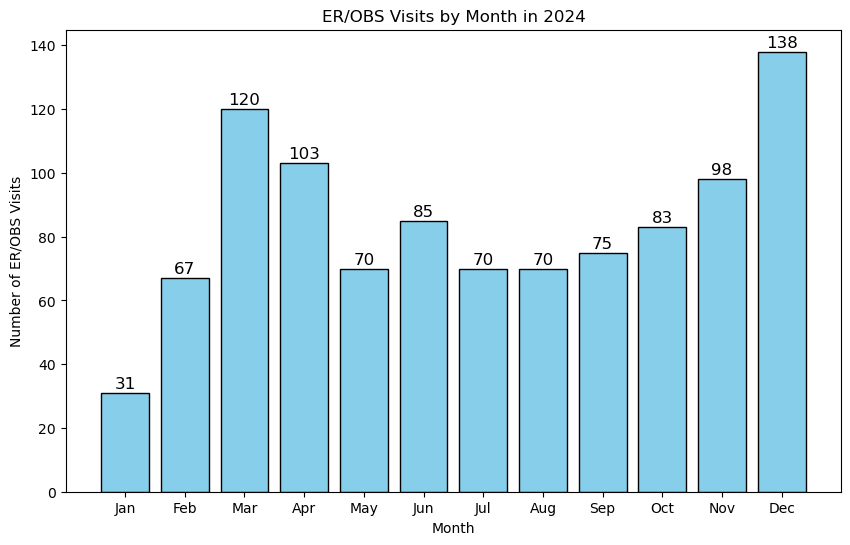

In [ ]:
# Ensure EventTime is in datetime format in your filtered DataFrame
df_filtered_er_obs_only['EventTime'] = pd.to_datetime(df_filtered_er_obs_only['EventTime'], errors='coerce')

# Filter to include only events that occurred in 2024
df_er_obs_2024 = df_filtered_er_obs_only[
    df_filtered_er_obs_only['EventTime'].between('2024-01-01', '2025-01-01')
].copy()

# Count how many rows remain
print("Number of ER/OBS visits in 2024 (filtered dataset):", df_er_obs_2024.shape[0])

# Create a new column for Month (1-12)
df_er_obs_2024['Month'] = df_er_obs_2024['EventTime'].dt.month

# Group by month and count visits
month_counts = df_er_obs_2024['Month'].value_counts().sort_index()

# Map month numbers to abbreviated names 
month_names = [calendar.month_abbr[m] for m in month_counts.index]

# Plot a bar chart of visits per month
plt.figure(figsize=(10, 6))
bars = plt.bar(month_names, month_counts, color='skyblue', edgecolor='black')
plt.xlabel("Month")
plt.ylabel("Number of ER/OBS Visits")
plt.title("ER/OBS Visits by Month in 2024")

# Annotate each bar with its count
for i, count in enumerate(month_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

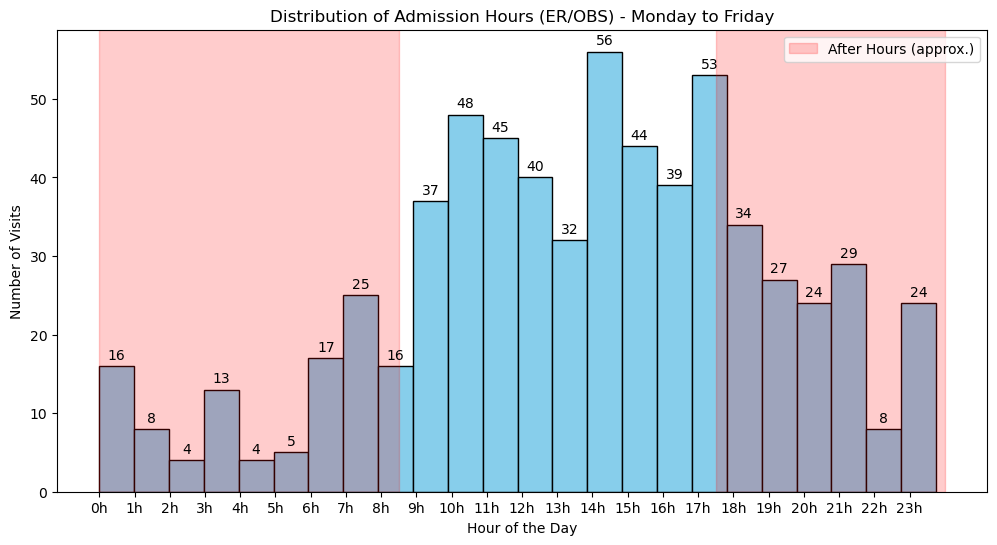

Number of Monday–Friday visits in dataset: 648


In [26]:
# Ensure 'Admit Timestamp' is in datetime format
df_filtered_er_obs_only['Admit Timestamp'] = pd.to_datetime(df_filtered_er_obs_only['Admit Timestamp'], errors='coerce')

# Filter to include only Monday–Friday (dayofweek 0=Monday, 4=Friday)
df_mf = df_filtered_er_obs_only[df_filtered_er_obs_only['Admit Timestamp'].dt.dayofweek < 5].copy()

# Create a fractional hour column (e.g., 8:30 AM => 8.5)
df_mf['AdmitHour'] = df_mf['Admit Timestamp'].dt.hour + df_mf['Admit Timestamp'].dt.minute / 60.0

# Plot a histogram of the AdmitHour for Monday–Friday
plt.figure(figsize=(12, 6))
counts_hist, bins, patches = plt.hist(
    df_mf['AdmitHour'].dropna(),
    bins=24,
    edgecolor='black',
    color='skyblue'
)

plt.title("Distribution of Admission Hours (ER/OBS) - Monday to Friday")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Visits")

# Highlight approximate after-hours: before 8:30 (8.5) and after 17:30 (17.5)
plt.axvspan(0, 8.5, color='red', alpha=0.2, label='After Hours (approx.)')
plt.axvspan(17.5, 24, color='red', alpha=0.2)

# Annotate each bar with its count
bin_width = bins[1] - bins[0]
for count, left_edge in zip(counts_hist, bins):
    plt.text(left_edge + bin_width/2, count + 0.5, str(int(count)),
             ha='center', va='bottom', fontsize=10)

# Customize x-axis ticks to show each hour
hours = list(range(24))
plt.xticks(hours, [f"{hour}h" for hour in hours])

plt.legend()
plt.show()

print(f"Number of Monday–Friday visits in dataset: {df_mf.shape[0]}")

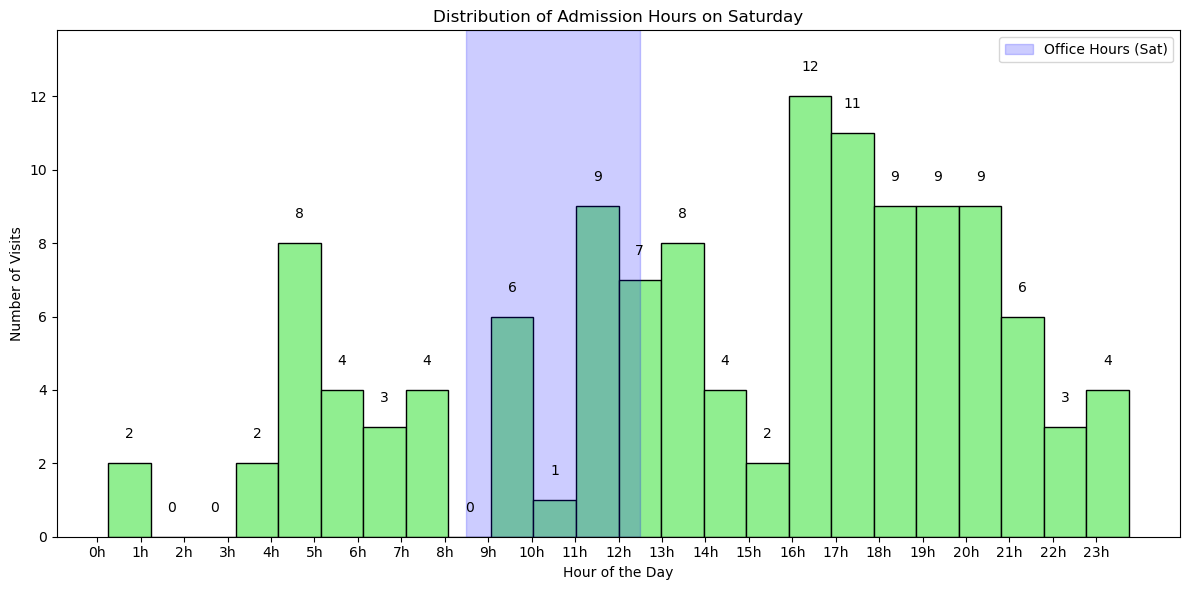

Number of visits on Saturday: 123


In [36]:
# Ensure 'Admit Timestamp' is in datetime format
df_filtered_er_obs_only['Admit Timestamp'] = pd.to_datetime(
    df_filtered_er_obs_only['Admit Timestamp'], errors='coerce'
)

# Filter the DataFrame for Saturday visits (dayofweek == 5)
df_saturday = df_filtered_er_obs_only[
    df_filtered_er_obs_only['Admit Timestamp'].dt.dayofweek == 5
].copy()

# Create a new column 'AdmitHour' that captures the fractional hour (e.g., 8:30 AM -> 8.5)
df_saturday['AdmitHour'] = (
    df_saturday['Admit Timestamp'].dt.hour +
    df_saturday['Admit Timestamp'].dt.minute / 60.0
)

# Plot a histogram of the AdmitHour for Saturday
plt.figure(figsize=(12, 6))
counts_hist, bins, patches = plt.hist(
    df_saturday['AdmitHour'].dropna(),
    bins=24,
    edgecolor='black',
    color='lightgreen'
)

plt.title("Distribution of Admission Hours on Saturday")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Visits")

# Set detailed x-axis ticks for each hour (0h to 23h)
hours = list(range(24))
plt.xticks(hours, [f"{hour}h" for hour in hours])

# For Saturday, the office is open from 8:30 AM to 12:30 PM
plt.axvspan(8.5, 12.5, color='blue', alpha=0.2, label='Office Hours (Sat)')

# Annotate each bar with its count, using a dynamic offset so labels never overlap
bin_width = bins[1] - bins[0]
max_height = counts_hist.max()
y_offset = max_height * 0.05  # 5% of the tallest bar

for count, left_edge in zip(counts_hist, bins[:-1]):
    plt.text(
        left_edge + bin_width/2,
        count + y_offset,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=10
    )

# Expand y-axis so labels have room above the tallest bar
plt.ylim(0, max_height + max_height * 0.15)

plt.legend()
plt.tight_layout()
plt.show()

print(f"Number of visits on Saturday: {df_saturday.shape[0]}")


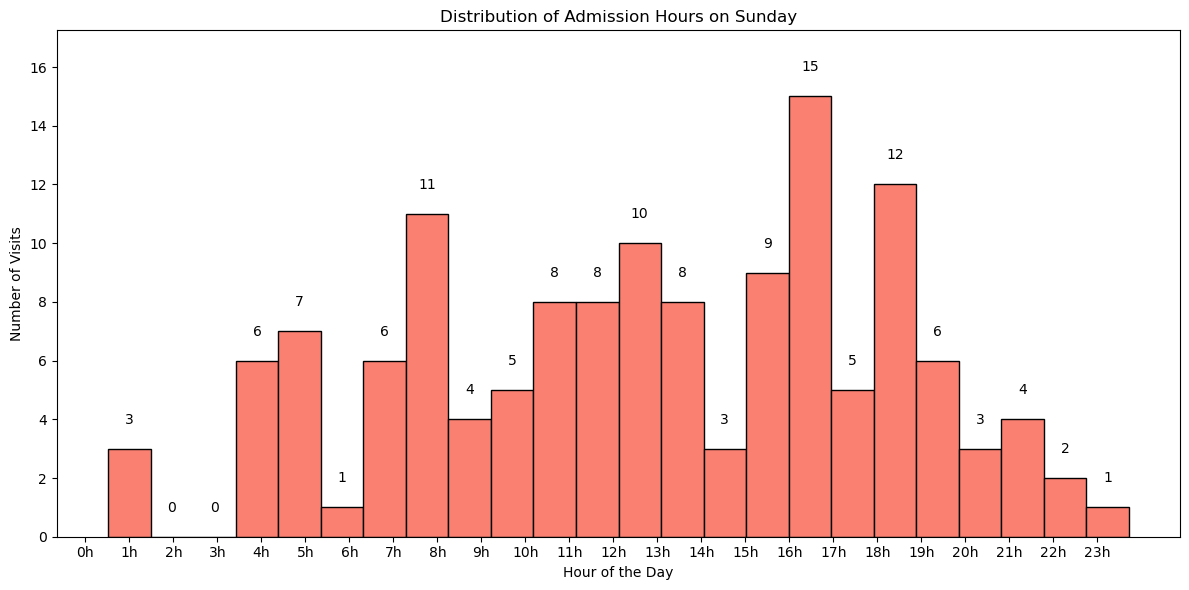

Number of visits on Sunday: 137


In [35]:
# Filter the DataFrame for Sunday visits (dayofweek == 6)
df_sunday = df_filtered_er_obs_only[
    df_filtered_er_obs_only['Admit Timestamp'].dt.dayofweek == 6
].copy()

# Create a new column 'AdmitHour' that captures the fractional hour (e.g., 8:30 AM -> 8.5)
df_sunday['AdmitHour'] = (
    df_sunday['Admit Timestamp'].dt.hour +
    df_sunday['Admit Timestamp'].dt.minute / 60.0
)

# Plot a histogram of the AdmitHour for Sunday
plt.figure(figsize=(12, 6))
counts_hist, bins, patches = plt.hist(
    df_sunday['AdmitHour'].dropna(),
    bins=24,
    edgecolor='black',
    color='salmon'
)

plt.title("Distribution of Admission Hours on Sunday")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Visits")

# Set detailed x-axis ticks for each hour (0h to 23h)
hours = list(range(24))
plt.xticks(hours, [f'{hour}h' for hour in hours])

# For Sunday, the office is closed (all visits are after hours), so no office hours highlighting is applied.

# Annotate each bar with its count, using a dynamic vertical offset
bin_width = bins[1] - bins[0]
max_height = counts_hist.max()
y_offset = max_height * 0.05

for count, left_edge in zip(counts_hist, bins[:-1]):
    plt.text(
        left_edge + bin_width/2,
        count + y_offset,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=10
    )

# Expand y-axis so labels never run off the top
plt.ylim(0, max_height + max_height * 0.15)

# Remove the legend call since no legend is needed
# plt.legend()
plt.tight_layout()
plt.show()

print(f"Number of visits on Sunday: {df_sunday.shape[0]}")

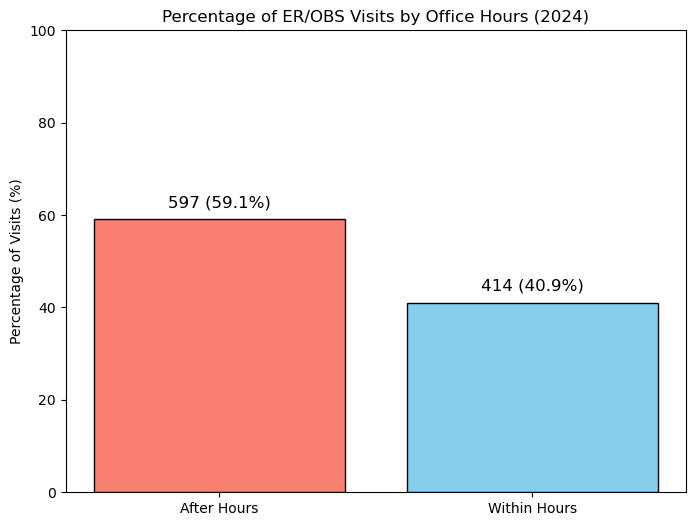

Total ER/OBS visits: 1011
After Hours visits: 597 (59.1%)
Within Hours visits: 414 (40.9%)


In [29]:

# Ensure 'Admit Timestamp' is in datetime format
df_filtered_er_obs_only['Admit Timestamp'] = pd.to_datetime(df_filtered_er_obs_only['Admit Timestamp'], errors='coerce')

# Define the office hours function
def is_after_hours(timestamp):
    """
    Returns True if the given timestamp is outside office hours, otherwise False.
    Office hours:
      - Monday to Friday: 8:30 AM to 5:30 PM
      - Saturday: 8:30 AM to 12:30 PM
      - Sunday: Closed (all visits considered after hours)
    """
    if pd.isnull(timestamp):
        return True  # Treat missing timestamps as after hours

    day = timestamp.dayofweek  # Monday = 0, ..., Sunday = 6
    current_time = timestamp.time()

    if day < 5:  # Monday to Friday
        start = datetime.time(8, 30)
        end = datetime.time(17, 30)
        return not (start <= current_time < end)
    elif day == 5:  # Saturday
        start = datetime.time(8, 30)
        end = datetime.time(12, 30)
        return not (start <= current_time < end)
    else:  # Sunday
        return True

# Create 'AfterHours' flag column
df_filtered_er_obs_only['AfterHours'] = df_filtered_er_obs_only['Admit Timestamp'].apply(is_after_hours)


# Count visits by After Hours vs. Within Hours
counts = df_filtered_er_obs_only['AfterHours'].value_counts()

# Mapping: True => "After Hours", False => "Within Hours"
after_hours_count = counts.get(True, 0)
within_hours_count = counts.get(False, 0)
total_visits = after_hours_count + within_hours_count

after_hours_pct = (after_hours_count / total_visits) * 100 if total_visits else 0
within_hours_pct = (within_hours_count / total_visits) * 100 if total_visits else 0


# Plot a bar chart for the two categories
plt.figure(figsize=(8, 6))
bars = plt.bar(["After Hours", "Within Hours"], [after_hours_pct, within_hours_pct],
               color=['salmon', 'skyblue'], edgecolor='black')
plt.title("Percentage of ER/OBS Visits by Office Hours (2024)")
plt.ylabel("Percentage of Visits (%)")
plt.ylim(0, 100)

# Annotate each bar with count and percentage
for bar, count_val, pct_val in zip(bars, [after_hours_count, within_hours_count], [after_hours_pct, within_hours_pct]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f"{count_val} ({pct_val:.1f}%)",
             ha='center', va='bottom', fontsize=12)

plt.show()


# Print summary counts
print(f"Total ER/OBS visits: {total_visits}")
print(f"After Hours visits: {after_hours_count} ({after_hours_pct:.1f}%)")
print(f"Within Hours visits: {within_hours_count} ({within_hours_pct:.1f}%)")

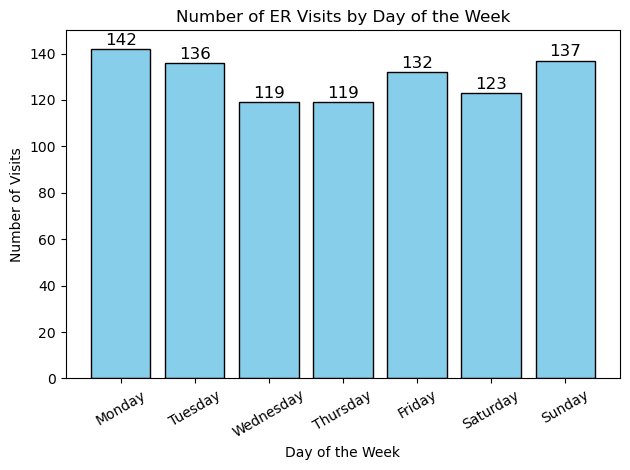

Day-of-week counts:
DayOfWeek
Monday       142
Tuesday      136
Wednesday    119
Thursday     119
Friday       132
Saturday     123
Sunday       137
Name: count, dtype: int64


In [ ]:
# Convert 'Admit Timestamp' to datetime if not already
df_filtered_er_obs_only['Admit Timestamp'] = pd.to_datetime(
    df_filtered_er_obs_only['Admit Timestamp'], errors='coerce'
)

# Extract the weekday name
df_filtered_er_obs_only['DayOfWeek'] = df_filtered_er_obs_only['Admit Timestamp'].dt.day_name()

# Count how many visits per weekday
day_counts = df_filtered_er_obs_only['DayOfWeek'].value_counts()

# Reorder days from Monday to Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(ordered_days, fill_value=0)

# Create a bar chart
bars = plt.bar(day_counts.index, day_counts.values, color='skyblue', edgecolor='black')
plt.title("Number of ER Visits by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Visits")

# Increase y-axis limit if needed
plt.ylim(0, 150)

# Annotate each bar with the count
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=12
    )

# Rotate x-axis labels slightly to prevent overlap
plt.xticks(rotation=30)
plt.tight_layout()  
plt.show()

# Print the day-of-week counts
print("Day-of-week counts:")
print(day_counts)